# Loader + KDE

In [1]:
import sys
sys.path.append('../codes')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np
import pylab as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from molnet.mnet import *

In [4]:
class Peak(object):
    def __init__(self, mz, rt, intensity, ms_level, filename, scan_number):
        self.mz = mz
        self.rt = rt
        self.intensity = intensity
        self.ms_level = ms_level
        self.filename = filename
        self.scan_number = scan_number

class Simulator(object):
    def __init__(self, min_ms1_intensity=0, min_ms2_intensity=0):
        self.data = {}
        self.ms1_peaks = []
        self.ms2_peaks = []
        self.ms1_precision = 5e-6
        self.obo_version = '4.0.1'
        self.min_ms1_intensity = min_ms1_intensity
        self.min_ms2_intensity = min_ms2_intensity
        self.bandwidths = 10 ** np.linspace(-1, 1, 40)
        self.kde = {}
        
    def load_data(self, data_path):
        for filename in glob.glob(os.path.join(data_path, '*.mzML')):
            run = pymzml.run.Reader(filename, obo_version = self.obo_version,
                                    MS1_Precision=self.ms1_precision,
                                    extraAccessions=[('MS:1000016', ['value', 'unitName'])])
            ms1 = []
            ms2 = []
            for nc, spectrum in enumerate(run):
                # if isinstance(spectrum, pymzml.spec.Chromatogram):
                #    print('chromatogram')
                for mz, intensity in spectrum.peaks('centroided'):
                    rt, units = spectrum.scan_time
                    if units == 'minute':
                        rt *= 60.0
                    ms_level = spectrum.ms_level
                    p = Peak(mz, rt, intensity, ms_level, filename, nc)
                    if ms_level == 1 and intensity > self.min_ms1_intensity:
                        ms1.append(p)
                    elif ms_level == 2 and intensity > self.min_ms2_intensity:
                        ms2.append(p)
            self.ms1_peaks.extend(ms1)
            self.ms2_peaks.extend(ms2)
            print('%s (ms1=%d, ms2=%d)' % (filename, len(ms1), len(ms2)))
                        
    def get_ms1_mz(self):
        return np.array(list(x.mz for x in self.ms1_peaks))[:, np.newaxis]     

    def get_ms1_rt(self):
        return np.array(list(x.rt for x in self.ms1_peaks))[:, np.newaxis]     

    def get_ms1_intensity(self):
        return np.array(list(x.intensity for x in self.ms1_peaks))[:, np.newaxis]     
    
    def get_log_ms1_mz(self):
        return np.log(self.get_ms1_mz())

    def get_log_ms1_intensity(self):
        return np.log(self.get_ms1_intensity())        
    
    def plot_histogram(self, data_type, bins=100):
        X = self._get_data(data_type)
        plt.figure()
        _ = plt.hist(X, bins=100)
        plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '|k')
        plt.title('%s histogram' % data_type)
        plt.show()
        
    def kde_cv(self, data_type, cv=2, plot=False):
        X = self._get_data(data_type)
        grid = GridSearchCV(KernelDensity(kernel='gaussian'), 
                            {'bandwidth': self.bandwidths},
                            cv=2, verbose=True, n_jobs=-1)
        grid.fit(X)
        
        bandwidth_cv = grid.best_params_['bandwidth']
        print('Best bandwidth: %.3f' % bandwidth_cv)        
        title = '%s density estimation - bandwidth %.3f' % (data_type, bandwidth_cv)
        kde = self._train_kde(bandwidth_cv, X)
        self._plot_kde(kde, X, title)
        self.kde[data_type] = kde
        
    def _get_data(self, data_type):
        if data_type == 'mz':
            X = self.get_log_ms1_mz()
        elif data_type == 'rt':
            X = self.get_ms1_rt()
        elif data_type == 'intensity':
            X = self.get_log_ms1_intensity()
        return X
                
    def _train_kde(self, bandwidth_cv, X):
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_cv).fit(X)
        return kde
        
    def _plot_kde(self, kde, X, title):
        X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
        log_dens = kde.score_samples(X_plot)                
        plt.figure()        
        plt.fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
        plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '|k')
        plt.title(title)
        plt.show()
        
    def sample(self, data_type, n_samples):
        samples = self.kde[data_type].sample(n_samples)
        if data_type == 'mz' or data_type == 'intensity':
            return np.exp(samples)
        elif data_type == 'rt':
            return samples
        
    def save(self, outfile):
        with open(outfile, 'wb') as f:
            pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)    
    
    @classmethod
    def load(cls, infile):
        with open(infile, 'rb') as f:        
            return pickle.load(f)

### Process Beer data

In [5]:
data_path = 'C:\\Users\\joewa\\Work\\clms\\\FourBeers_mzML_files\\test\\'
sim = Simulator(min_ms1_intensity=2500000, min_ms2_intensity=5000)

In [6]:
sim.load_data(data_path)

C:\Users\joewa\Work\clms\\FourBeers_mzML_files\test\Beer_1_T10_POS.mzML (ms1=15022, ms2=80212)


In [7]:
sim.save('../models/sim_4beers.pkl')

In [8]:
sim = Simulator.load('../models/sim_4beers.pkl')

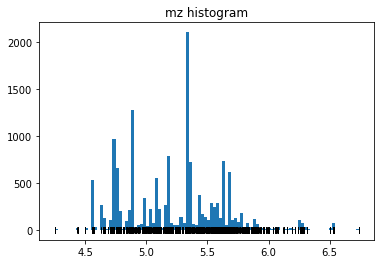

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   55.6s finished


Best bandwidth: 0.127


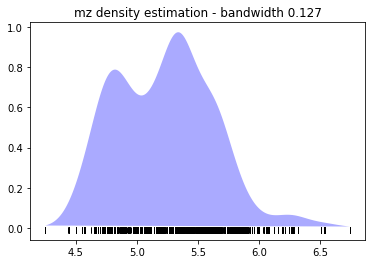

array([[214.8684764 ],
       [188.34114299],
       [110.17784329],
       [329.33116941],
       [189.80724299],
       [171.19895484],
       [300.52111458],
       [115.13077751],
       [325.39069616],
       [210.7557012 ],
       [208.89931745],
       [183.96030962],
       [163.47362674],
       [280.36378652],
       [304.85948708],
       [186.02645849],
       [149.71416253],
       [ 82.12959706],
       [110.30102779],
       [194.16534364]])

In [10]:
data_type = 'mz'
sim.plot_histogram(data_type)
sim.kde_cv(data_type, cv=2, plot=True)
sim.sample(data_type, 20)

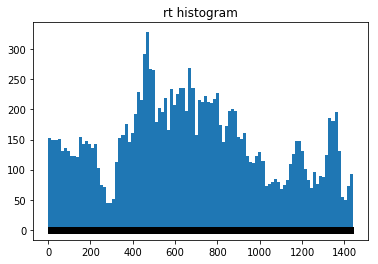

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   29.8s finished


Best bandwidth: 10.000


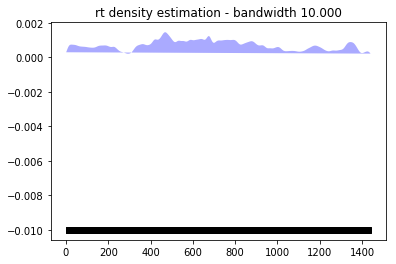

array([[ 641.07420353],
       [ 428.34532856],
       [ 987.82227199],
       [ 924.10268021],
       [ 422.30081319],
       [1281.37244799],
       [ 424.72633243],
       [ 799.45854867],
       [1264.9472422 ],
       [ 442.11464341],
       [ 611.38048304],
       [ 652.78219674],
       [ 402.21242245],
       [ 205.93702667],
       [ 453.76558656],
       [ 120.30949207],
       [ 769.58800104],
       [ 449.49950687],
       [ 723.94751124],
       [  26.3468628 ]])

In [11]:
data_type = 'rt'
sim.plot_histogram(data_type)
sim.kde_cv(data_type, cv=2, plot=True)
sim.sample(data_type, 20)

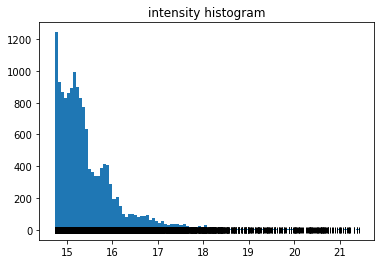

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished


Best bandwidth: 0.100


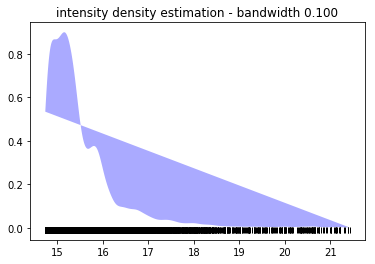

array([[ 6562751.73246467],
       [ 3420308.37370891],
       [ 3881572.55361773],
       [ 4740543.12436863],
       [ 2821814.91932247],
       [ 2924441.19630253],
       [37318982.14240795],
       [ 4395771.44522251],
       [ 3331582.49037928],
       [ 7855675.99227888],
       [ 7895528.6048943 ],
       [ 4192068.23182442],
       [ 7600897.66451862],
       [ 7211639.61912417],
       [ 4347675.97316372],
       [28675438.39881999],
       [ 7489719.65964613],
       [ 3257911.38882737],
       [ 3034740.61400142],
       [ 4807579.37729304]])

In [12]:
data_type = 'intensity'
sim.plot_histogram(data_type)
sim.kde_cv(data_type, cv=2, plot=True)
sim.sample(data_type, 20)

In [13]:
sim.save('../models/sim_4beers.pkl')